# Predicting hotel reviews rating

With the increasing availability of social feedback on platforms such as Yelp or TripAdvisor, more and more customers consult reviews before making their next decision about a purchase, airplane ticket or hotel reservation. In the case of hotels, 90% of travelers agree that reviews are influential when making a decision on where to stay. These customers also trust the reviews that they find as much as personal recommendations (Brightlocal.com). If reviews are not positive enough, it could amount to losing 88% of web traffic that references reviews. In addition, 75% of consumers complete a call to action after reading a great review.

From the business perspective, customer reviews contain a large amount of information that can help identify current issues and fix them, customer satisfaction, and customer loyalty. However, in order to obtain this information, involves reading through a great number of these reviews, which in turn, may required a number of readers analyzing the texts for a large number of hours.

This project aims to helping with this issue, specifically hotel reviews, by applying NLP to catalog customer reviews as positive or negative.

The main benefit of this product is to save hours of going through the reviews and follow a consistent pattern in cataloging them. In addition, for those reviews that are not accompanied by a rating (eg. 3 stars), this product will be able to make predictions as to the review rating. By saving the bussiness working hours, this time can be spent in other tasks such as targeting issues or implementing new marketing strategies. Thus, the main beneficiaries of these product are hotel companies as well as online platforms dedicated to provide a place to stay. 

## Data

The dataset used for this project contains 35050 reviews for hotels in the United States. In addition to the review itself, a review title is provided as well as the hotel rating (from 0 to 10). Metadata about the hotel being reviewed is also provided: name, address, category, date. Metadata about the reviewer is also provided: username, city, and province.  

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
plt.style.use('ggplot')
%matplotlib inline

import re

from wordcloud import STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_curve, auc

from sklearn.utils import resample

In [3]:
data = pd.read_csv('/Users/danielvalle/Documents/Coding/Springboard/Capstone project 2 - NLP/Hotel reviews.csv', encoding='latin-1')

In [4]:
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt lÀ_À_ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,À_À_À_À_À_À_ À_À_À_À_À_À_À_À_À_...,NaN,sungchul,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35912 entries, 0 to 35911
Data columns (total 19 columns):
address                 35912 non-null object
categories              35912 non-null object
city                    35912 non-null object
country                 35912 non-null object
latitude                35826 non-null float64
longitude               35826 non-null float64
name                    35912 non-null object
postalCode              35857 non-null object
province                35912 non-null object
reviews.date            35653 non-null object
reviews.dateAdded       35912 non-null object
reviews.doRecommend     0 non-null float64
reviews.id              0 non-null float64
reviews.rating          35050 non-null float64
reviews.text            35890 non-null object
reviews.title           34290 non-null object
reviews.userCity        16263 non-null object
reviews.username        35869 non-null object
reviews.userProvince    17518 non-null object
dtypes: float64(5), 

## Data wrangling and cleaning

First, those reviews which do not show a rating will be dropped since they do not help us in establishing the ground truth for the sentiment associated with the review. 

As a starting point, reviews rated as 5 or higher will be considered positive while those rated below 4 will be considered as negative. From this, we can see that negative reviews outnumber positive ones. We will keep this in mind for considering techniques to deal with imbalanced data. 

Then, we move on to cleaning the text: make sure that reviews are strings, convert them to lower case and delete non alphanumerical characters. 

Then, we are ready to split the data into train and test sets. In the next step, we fit and transform each review in the train set into a numerical vector having as features each each word (attested at least two times) and contiguous sequences of two words (bigrams). Then, this matrix is further fitted and transformed via tf-idf. A similar process is applied to the test data with the difference that only the transformations are applied; the fitting step is skip since the same fitting of the train data is used in order to allow for the same set of features (words and bigrams) in both train and test samples. During this process of fitting and transformation, stopwords were also removed.

In [6]:
# Drop null values of ratings
data = data[data['reviews.rating'].notnull()]

In [7]:
# Create column with binary values for sentiment
data["sentiment"] = [1 if x >= 5 else 0 for x in data['reviews.rating']]

Text(0.5,1,"Hotel review sentiment (1 = 'positive')")

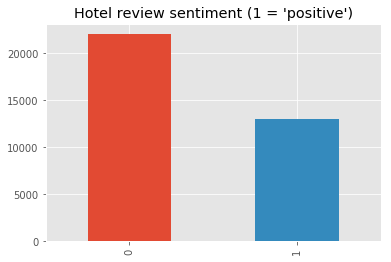

In [8]:
data.sentiment.value_counts().plot(kind='bar')
plt.title("Hotel review sentiment (1 = 'positive')")

In [9]:
# Cleaning text
def clean(review):
        review = str(review)
        review = str(review.lower())  # Lower case
        review = re.compile('[^a-z]+').sub(' ', str(review)).strip() # Remove non alphabetical numbers
        return review

# Add column review cleaned    
data['review_cleaned'] = [clean(x) for x in data['reviews.text']]

In [10]:
# Sanity check
print(data['reviews.text'][0])
print('-----------')
print(data['review_cleaned'][0])

Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work very well. Take mosquito repelant!
-----------
pleasant min walk along the sea front to the water bus restaurants etc hotel was comfortable breakfast was good quite a variety room aircon didn t work very well take mosquito repelant


In [11]:
# Split dataset into train and test
data_senti = data[["sentiment" , "review_cleaned"]]
train = data_senti.sample(frac=0.8,random_state=200)
test = data_senti.drop(train.index)

print(len(train))
print(len(test))

28040
7010


In [12]:
# Call up stopwords
stopwords = STOPWORDS
stopwords.remove('not')
stopwords.remove('no')

In [13]:
# Vectorize reviews for classification: random forest, linear regression, SVM, BernouliNB, etc

# Call tfidf vectorizer, fit and transform the data 
count_vect = CountVectorizer(min_df = 2, stop_words = stopwords , ngram_range = (1,2))
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(train["review_cleaned"])        
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(test["review_cleaned"])        
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

#tfidf_vect = TfidfVectorizer(min_df = 2, stop_words = stopwords, ngram_range=(1, 2))
#X_train_tfidf = tfidf_vect.fit_transform(train['review_cleaned'])
#X_test_tfidf = tfidf_vect.fit_transform(test['review_cleaned'])

y_train = train['sentiment']
y_test = test['sentiment']

In [14]:
# Evaluate dimensionality
print('X_train:', X_train_tfidf.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test_tfidf.shape)
print('y_test:', y_test.shape)

X_train: (28040, 89627)
y_train: (28040,)
X_test: (7010, 89627)
y_test: (7010,)


In [15]:
# Instantiate different classifiers
#logreg = linear_model.LogisticRegression(solver='lbfgs' , C=10000)  # Logistic regression
#multi_NB = MultinomialNB()   # Multinomial naive bayes
#b_NB = BernoulliNB()   # Bernoulli naive bayes
#rf = RandomForestRegressor(n_estimators=20, max_depth=30, random_state=30)  # Random forest

# SVM won't be used because of its difficulty to scale


# Set up lists to store models, results and names
#models = []

#models.append(('LR', logreg))
#models.append(('Multi_NB', multi_NB))
#models.append(('Bernoulli_NB', b_NB))
#models.append(('Random_forest', rf))
    
#results = []
#names = []

## Training the model

Given that we are trying to predict whether the review was positive or negative, this involves a binary classification task. Since there is a variety of classifiers for this task with different strengths and weakneses, we attempt to try some of the compare their performace. Here we will be testing the following classifiers: Logistic Regression, Multinomial N(aive) B(ayes), Bernoulli N(aive) B(ayes), Random Fores and KNeighbors classifier. 

These classifiers will be evaluated with regard to their accuracy in both the train and test data, prediction accuracy and log loss. A dataframe is created to store this information and another dataframe to contain the review predictions for each classifier. 

After running the models, we find the the BernoulliNB classifier obtains the highest performance: 75.69%. Furthermore, it is the BernoulliNB classifier that also has the highest ROC AUC value: .77. 

In [16]:
classifiers = [linear_model.LogisticRegression(solver='lbfgs' , C=10000), 
              MultinomialNB(), 
              BernoulliNB(), 
              RandomForestClassifier(n_estimators=20, max_depth=30, random_state=30), 
              KNeighborsClassifier()]

In [17]:
# Create a dataframe with results
results_cols = ['Classifier', 'Train score', 'Test score', 'Accuracy', 'Log Loss']
results = pd.DataFrame(columns = results_cols)

predictions_cols = ['Logistic_regression', 'MultinomialNB', 'BernoulliNB', 'RandomForest', 'KNeighbors']
predictions = pd.DataFrame()

In [18]:
# Run classifiers

for clf in classifiers:
    clf.fit(X_train_tfidf, y_train)
    
    name = clf.__class__.__name__
    
    print('='*30)
    print(name)
    
    print('**** Results ****')
    train_score = clf.score(X_train_tfidf, y_train)
    test_score = clf.score(X_test_tfidf, y_test)
    print('Train score: {:.4%}'.format(train_score))
    print('Test score: {:.4%}'.format(test_score))
    
    prediction = clf.predict(X_test_tfidf)
    acc = accuracy_score(y_test, prediction)
    print("Accuracy: {:.4%}".format(acc))
    log_predictions = pd.DataFrame(prediction.tolist())
    predictions = pd.concat([predictions, log_predictions], axis = 1)
    
    
    train_predictions = clf.predict_proba(X_test_tfidf)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    #acc and ll have been removed
    log_entry = pd.DataFrame([[name, train_score, test_score, acc, ll]], columns = results_cols)
    results = results.append(log_entry)

LogisticRegression
**** Results ****
Train score: 98.0884%
Test score: 73.1954%
Accuracy: 73.1954%
Log Loss: 1.599029948996817
MultinomialNB
**** Results ****
Train score: 83.4629%
Test score: 74.2939%
Accuracy: 74.2939%
Log Loss: 0.49556609892741993
BernoulliNB
**** Results ****
Train score: 82.7960%
Test score: 75.6919%
Accuracy: 75.6919%
Log Loss: 1.461166745324262
RandomForestClassifier
**** Results ****
Train score: 72.3502%
Test score: 66.8616%
Accuracy: 66.8616%
Log Loss: 0.5856102467161411
KNeighborsClassifier
**** Results ****
Train score: 72.8174%
Test score: 57.7746%
Accuracy: 57.7746%
Log Loss: 1.7583295665041503


In [19]:
# Check out results
results.head()

,Classifier,Train score,Test score,Accuracy,Log Loss
0,LogisticRegression,0.980884,0.731954,0.731954,1.599030
0,MultinomialNB,0.834629,0.742939,0.742939,0.495566
0,BernoulliNB,0.827960,0.756919,0.756919,1.461167
0,RandomForestClassifier,0.723502,0.668616,0.668616,0.585610
0,KNeighborsClassifier,0.728174,0.577746,0.577746,1.758330


In [20]:
# Check out results: predictions
predictions.columns = predictions_cols
print(predictions.head())
print(predictions.shape)

   Logistic_regression  MultinomialNB  BernoulliNB  RandomForest  KNeighbors
0                    0              0            1             0           1
1                    0              0            1             0           1
2                    0              1            1             1           1
3                    0              1            1             1           0
4                    1              0            0             0           0
(7010, 5)


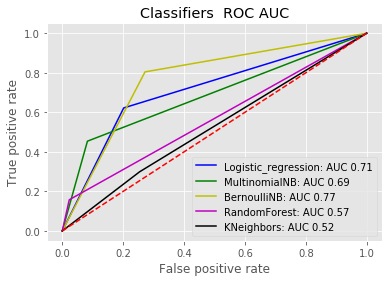

In [21]:
# Further metrics ROC

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predict in predictions.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers  ROC AUC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.show()

## Further steps

The next steps of this project involve mainly improving the model performance. For this, a number of different approaches will be tried:

    - Keep the difference in (upper) case in certain words that could help the classifier make the class distinction. 
    - Adjust the rating threshold in order to show better the contrast between positive and negative review, e.g. have a more polarized system for classifying rewies. 
    - Add additional models to evaluate their performance. 
    - Tune manually the models hyperparameters using grid serach.
    - Add additional features to be used by the classifiers: metadata, review title, etc. 
    - Try a model using neural networks. 

### Change the threshold for review sentiment

In [22]:
# Reorganize the data into positive and negative reviews with a more conservative margin
# Positive => 7; Negative =< 3

# Create column with binary values for sentiment
data["sentiment_conservative"] = [1 if x >= 6 else 0 if x <= 3 else 'None' for x in data['reviews.rating']]
print(data['sentiment_conservative'].value_counts()) 

# Create data_cs with only the positive and negative values 
data_cs = data.loc[data['sentiment_conservative'].isin([1,0])]
print(len(data_cs))
print(data_cs['sentiment_conservative'].value_counts())

None    22605
0       12103
1         342
Name: sentiment_conservative, dtype: int64
12445
0    12103
1      342
Name: sentiment_conservative, dtype: int64


Notice the highly imbalanced data obtained with a strong bias towards the negative class. In order to account for this, we will upsample the positive class and downsample the negative class. 

In [23]:
# Resampling: upsampling and downsampling

# Separate the classes
positive_cs = data_cs[data_cs.sentiment_conservative == 1]
negative_cs = data_cs[data_cs.sentiment_conservative != 1]

# Perform up and downsampling
positive_cs_upsample = resample(positive_cs, replace=True, n_samples=1500, random_state=123)
negative_cs_downsample = resample(negative_cs, replace=False, n_samples=1500, random_state=123)

# Concatenate the resampled dataframes
data_cs_resampled = pd.concat([positive_cs_upsample, negative_cs_downsample])

# Split dataset into train and test
data_senti_cs_resampled = data_cs_resampled[["sentiment_conservative" , "review_cleaned"]] # dataframe with only 2 columns
train_cs_resampled = data_senti_cs_resampled.sample(frac=0.8,random_state=200)
test_cs_resampled = data_senti_cs_resampled.drop(train.index)

In [24]:
# Vectorize reviews from resampled dataset
X_train_counts_cs_resampled = count_vect.fit_transform(train_cs_resampled["review_cleaned"])        
X_train_tfidf_cs_resampled = tfidf_transformer.fit_transform(X_train_counts_cs_resampled)

X_test_counts_cs_resampled = count_vect.transform(test_cs_resampled["review_cleaned"])        
X_test_tfidf_cs_resampled = tfidf_transformer.transform(X_test_counts_cs_resampled)

y_train_cs_resampled = train_cs_resampled['sentiment_conservative'].astype('int')
y_test_cs_resampled = test_cs_resampled['sentiment_conservative'].astype('int')

In [25]:
# Run the classifiers

# Create list of classifiers
classifiers_cs_resampled = [linear_model.LogisticRegression(solver='lbfgs' , C=10000), 
              MultinomialNB(), 
              BernoulliNB(), 
              RandomForestClassifier(n_estimators=20, max_depth=30, random_state=30), 
              KNeighborsClassifier()]

# Create a dataframe with results
results_cols_cs_resampled = ['Classifier', 'Train score', 'Test score', 'Accuracy', 'Log Loss']
results_cs_resampled = pd.DataFrame(columns = results_cols)

predictions_cols_cs_resampled = ['Logistic_regression', 'MultinomialNB', 'BernoulliNB', 'RandomForest', 'KNeighbors']
predictions_cs_resampled = pd.DataFrame()

# Run classifiers

for clf in classifiers_cs_resampled:
    clf.fit(X_train_tfidf_cs_resampled, y_train_cs_resampled)
    
    name = clf.__class__.__name__
    
    print('='*30)
    print(name)
    
    print('**** Results ****')
    train_score = clf.score(X_train_tfidf_cs_resampled, y_train_cs_resampled)
    test_score = clf.score(X_test_tfidf_cs_resampled, y_test_cs_resampled)
    print('Train score: {:.4%}'.format(train_score))
    print('Test score: {:.4%}'.format(test_score))
    
    prediction = clf.predict(X_test_tfidf_cs_resampled)
    acc = accuracy_score(y_test_cs_resampled, prediction)
    print("Accuracy: {:.4%}".format(acc))
    log_predictions = pd.DataFrame(prediction.tolist())
    predictions_cs_resampled = pd.concat([predictions_cs_resampled, log_predictions], axis = 1)
    
    
    train_predictions = clf.predict_proba(X_test_tfidf_cs_resampled)
    ll = log_loss(y_test_cs_resampled, train_predictions)
    print("Log Loss: {}".format(ll))
    
    #acc and ll have been removed
    log_entry = pd.DataFrame([[name, train_score, test_score, acc, ll]], columns = results_cols_cs_resampled)
    results_cs_resampled = results_cs_resampled.append(log_entry)

LogisticRegression
**** Results ****
Train score: 99.9583%
Test score: 99.3092%
Accuracy: 99.3092%
Log Loss: 0.015718726019979153
MultinomialNB
**** Results ****
Train score: 98.1667%
Test score: 97.4093%
Accuracy: 97.4093%
Log Loss: 0.1624447931612195
BernoulliNB
**** Results ****
Train score: 90.7500%
Test score: 91.3644%
Accuracy: 91.3644%
Log Loss: 0.35380962933480803
RandomForestClassifier
**** Results ****
Train score: 96.8333%
Test score: 94.1278%
Accuracy: 94.1278%
Log Loss: 0.31145346835904997
KNeighborsClassifier
**** Results ****
Train score: 92.8333%
Test score: 92.2280%
Accuracy: 92.2280%
Log Loss: 0.22132969487484686


Notice that all these models seem to perform very well, higher than 90% each. This is a little bit too suspicious. Find possible causes for this. 

In [26]:
# Check out results: predictions
predictions_cs_resampled.columns = predictions_cols_cs_resampled
print(predictions_cs_resampled.head())
print(predictions_cs_resampled.shape)

   Logistic_regression  MultinomialNB  BernoulliNB  RandomForest  KNeighbors
0                    1              1            1             1           1
1                    1              1            0             0           1
2                    1              1            0             1           1
3                    1              1            1             1           1
4                    1              1            1             1           1
(579, 5)


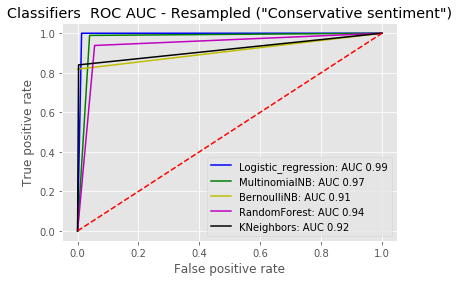

In [27]:
# Further metrics ROC of resampled sentiment conservative data

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predict in predictions_cs_resampled.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_cs_resampled, predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers  ROC AUC - Resampled ("Conservative sentiment")')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.show()

### Neural network analysis

In [27]:
# Neural network analysis

# Pre_process data
# Note this data has 1 for reviews >=5 and 0 for everyting lower

# Convert target data into categorical and then to a matrix
from keras.utils import to_categorical

y_nn = to_categorical(data_senti.sentiment)
y_nn = np.asmatrix(y_nn)

# Create data for variable X
X_nn = data_senti.review_cleaned
X_nn = count_vect.fit_transform(X_nn)        
X_nn = tfidf_transformer.fit_transform(X_nn)

print(X_nn.shape)
print(y_nn.shape)
print(type(X_nn))
print(type(y_nn))

Using TensorFlow backend.


(35050, 110680)
(35050, 2)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>


In [29]:
# Create a simple neural network

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

input_shape = X_nn.shape[1]
early_stopping_monitor = EarlyStopping(patience=2)

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(input_shape, ))) #Input shape: number of columns of X
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_nn, y_nn, validation_split=0.25, epochs=20, callbacks=[early_stopping_monitor])

Train on 26287 samples, validate on 8763 samples
Epoch 1/20
26287/26287 [==============================] - 142s 5ms/step - loss: 0.4918 - acc: 0.7525 - val_loss: 0.4943 - val_acc: 0.7455
Epoch 2/20
26287/26287 [==============================] - 165s 6ms/step - loss: 0.2426 - acc: 0.8979 - val_loss: 0.5861 - val_acc: 0.7290
Epoch 3/20
26287/26287 [==============================] - 169s 6ms/step - loss: 0.1100 - acc: 0.9513 - val_loss: 0.7494 - val_acc: 0.7242


In [30]:
# Neural netwrok with two hidden layers (100 nodes each)
model_2 = Sequential()
model_2.add(Dense(100, activation='relu', input_shape=(input_shape, ))) #Input shape: number of columns of X
model_2.add(Dense(100, activation='relu'))
model_2.add(Dense(2, activation='softmax'))
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.fit(X_nn, y_nn, validation_split=0.25, epochs=20, callbacks=[early_stopping_monitor])

Train on 26287 samples, validate on 8763 samples
Epoch 1/20
26287/26287 [==============================] - 163s 6ms/step - loss: 0.4903 - acc: 0.7533 - val_loss: 0.4938 - val_acc: 0.7469
Epoch 2/20
26287/26287 [==============================] - 147s 6ms/step - loss: 0.2126 - acc: 0.9074 - val_loss: 0.6426 - val_acc: 0.7273
Epoch 3/20
26287/26287 [==============================] - 157s 6ms/step - loss: 0.0933 - acc: 0.9553 - val_loss: 0.9220 - val_acc: 0.7185


In [31]:
# Model 3: 1 hidden layer, 250 nodes
model_3 = Sequential()
model_3.add(Dense(250, activation='relu', input_shape=(input_shape, ))) #Input shape: number of columns of X
model_3.add(Dense(2, activation='softmax'))
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_3.fit(X_nn, y_nn, validation_split=0.25, epochs=20, callbacks=[early_stopping_monitor])

Train on 26287 samples, validate on 8763 samples
Epoch 1/20
26287/26287 [==============================] - 340s 13ms/step - loss: 0.4893 - acc: 0.7545 - val_loss: 0.4927 - val_acc: 0.7508
Epoch 2/20
26287/26287 [==============================] - 309s 12ms/step - loss: 0.2222 - acc: 0.9025 - val_loss: 0.6282 - val_acc: 0.7220
Epoch 3/20
26287/26287 [==============================] - 334s 13ms/step - loss: 0.0991 - acc: 0.9554 - val_loss: 0.8053 - val_acc: 0.7200


### Neural networks

Notice that the three neural networks models tried here produce results less accurate than the BernoulliNB (75%). Maybe more data could make the neural network performance better. 

In [32]:
### Neural networks second part

# Import keras tokenizer
from keras.preprocessing.text import Tokenizer

def nn_tokenizer(data, mode):
    '''Define function to convert X text data into numerical data though different tokenization modes'''
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    X_nn = tokenizer.texts_to_matrix(data, mode=mode)
    return X_nn

In [33]:
# Define a simple model for neural network

def snn_model(X, y, input_shape):
    '''Define a model, compile and fit it: return accuracy scores'''
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(input_shape, ))) #Input shape: number of columns of X
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X, y, validation_split=0.25, epochs=20, callbacks=[early_stopping_monitor], verbose=2)
    scores.append(history.history.keys())

In [34]:
# Define different modes
modes = ['binary', 'count', 'tfidf', 'freq']

# Define list of scores to record the results
scores = []

# Run the different methods and score the scores

for mode in modes:
    X_nn = nn_tokenizer(data_senti.review_cleaned, mode)
    input_shape = X_nn.shape[1] 
    snn_model(X_nn, y_nn, input_shape=input_shape)

Train on 26287 samples, validate on 8763 samples
Epoch 1/20
 - 37s - loss: 0.4901 - acc: 0.7593 - val_loss: 0.4949 - val_acc: 0.7503
Epoch 2/20
 - 41s - loss: 0.3726 - acc: 0.8244 - val_loss: 0.5330 - val_acc: 0.7439
Epoch 3/20
 - 33s - loss: 0.2785 - acc: 0.8766 - val_loss: 0.6195 - val_acc: 0.7374
Train on 26287 samples, validate on 8763 samples
Epoch 1/20
 - 39s - loss: 0.4886 - acc: 0.7611 - val_loss: 0.4928 - val_acc: 0.7553
Epoch 2/20
 - 36s - loss: 0.3700 - acc: 0.8269 - val_loss: 0.5391 - val_acc: 0.7446
Epoch 3/20
 - 32s - loss: 0.2757 - acc: 0.8808 - val_loss: 0.6134 - val_acc: 0.7431
Train on 26287 samples, validate on 8763 samples
Epoch 1/20
 - 36s - loss: 0.5000 - acc: 0.7590 - val_loss: 0.5046 - val_acc: 0.7519
Epoch 2/20
 - 46s - loss: 0.3326 - acc: 0.8477 - val_loss: 0.5741 - val_acc: 0.7372
Epoch 3/20
 - 32s - loss: 0.2260 - acc: 0.9038 - val_loss: 0.7163 - val_acc: 0.7291
Train on 26287 samples, validate on 8763 samples
Epoch 1/20
 - 40s - loss: 0.5462 - acc: 0.7216 -

It looks like the neural network performance is relatively the same with respect to the mode of tokenization used with slightly higher values for binary and frequency modes. 

## Part of speech tagging

In [28]:
# Add pos tagging to the bag of words
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Create column with cleaned text (str, lower case); tokenize it and add part of speech    
data['pos'] = [clean(x) for x in data['reviews.text']]
print(data['pos'][0])
(print('=' * 30))

# Remove stop words
stoplist = set(stopwords.words('english'))
data['pos'] = data['pos'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))
print(data['pos'][0])
(print('=' * 30))

# Tokenize and add part of speech
data['pos'] = [pos_tag(word_tokenize(x)) for x in data['pos']]
print(data['pos'][0])
(print('=' * 30))

# Join tuples into a single string for each row
data['pos'] = [[''.join(tup) for tup in row] for row in data['pos']]
print(data['pos'][0])
(print('=' * 30))

# Convert a list of strings into a single string
data['pos'] = [' '.join(x) for x in data['pos']]
print(data['pos'][0])

pleasant min walk along the sea front to the water bus restaurants etc hotel was comfortable breakfast was good quite a variety room aircon didn t work very well take mosquito repelant
pleasant min walk along sea front water bus restaurants etc hotel comfortable breakfast good quite variety room aircon work well take mosquito repelant
[('pleasant', 'JJ'), ('min', 'NN'), ('walk', 'NN'), ('along', 'IN'), ('sea', 'NN'), ('front', 'JJ'), ('water', 'NN'), ('bus', 'NN'), ('restaurants', 'NNS'), ('etc', 'JJ'), ('hotel', 'NN'), ('comfortable', 'JJ'), ('breakfast', 'NN'), ('good', 'JJ'), ('quite', 'RB'), ('variety', 'NN'), ('room', 'NN'), ('aircon', 'NN'), ('work', 'NN'), ('well', 'RB'), ('take', 'VB'), ('mosquito', 'NN'), ('repelant', 'NN')]
['pleasantJJ', 'minNN', 'walkNN', 'alongIN', 'seaNN', 'frontJJ', 'waterNN', 'busNN', 'restaurantsNNS', 'etcJJ', 'hotelNN', 'comfortableJJ', 'breakfastNN', 'goodJJ', 'quiteRB', 'varietyNN', 'roomNN', 'airconNN', 'workNN', 'wellRB', 'takeVB', 'mosquitoNN', '

In [29]:
# Split dataset into train and test
data_pos = data[["sentiment" , "pos"]]
train_pos = data_pos.sample(frac=0.8,random_state=200)
test_pos = data_pos.drop(train_pos.index)

print(len(train_pos))
print(len(test_pos))

28040
7010


In [30]:
print(train_pos['pos'][0])
print(type(train_pos['pos'][0]))

pleasantJJ minNN walkNN alongIN seaNN frontJJ waterNN busNN restaurantsNNS etcJJ hotelNN comfortableJJ breakfastNN goodJJ quiteRB varietyNN roomNN airconNN workNN wellRB takeVB mosquitoNN repelantNN
<class 'str'>


In [31]:
# Vectorize reviews for classification: random forest, linear regression, SVM, BernouliNB, etc

# Call tfidf vectorizer, fit and transform the data 
count_vect = CountVectorizer(min_df = 2, stop_words = None, ngram_range = (1, 2))
tfidf_transformer = TfidfTransformer()

X_train_pos_counts = count_vect.fit_transform(train_pos["pos"])        
X_train_pos_tfidf = tfidf_transformer.fit_transform(X_train_pos_counts)

X_test_pos_counts = count_vect.transform(test_pos["pos"])        
X_test_pos_tfidf = tfidf_transformer.transform(X_test_pos_counts)

y_train = train_pos['sentiment']
y_test = test_pos['sentiment']

In [32]:
# Define a function to run the classifiers
def run_classifiers(X_train, X_test, y_train, y_test, classifiers):
    # Create a dataframe with results
    results_cols = ['Classifier', 'Train score', 'Test score', 'Accuracy', 'Log Loss']
    results = pd.DataFrame(columns = results_cols)

    predictions_cols = ['Logistic_regression', 'MultinomialNB', 'BernoulliNB', 'RandomForest', 'KNeighbors']
    predictions = pd.DataFrame()

    for clf in classifiers:
        clf.fit(X_train, y_train)
    
        name = clf.__class__.__name__
    
        print('='*30)
        print(name)
    
        print('**** Results ****')
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        print('Train score: {:.4%}'.format(train_score))
        print('Test score: {:.4%}'.format(test_score))
    
        prediction = clf.predict(X_test)
        acc = accuracy_score(y_test, prediction)
        print("Accuracy: {:.4%}".format(acc))
        log_predictions = pd.DataFrame(prediction.tolist())
        predictions = pd.concat([predictions, log_predictions], axis = 1)
    
    
        train_predictions = clf.predict_proba(X_test)
        ll = log_loss(y_test, train_predictions)
        print("Log Loss: {}".format(ll))
    
        #acc and ll have been removed
        log_entry = pd.DataFrame([[name, train_score, test_score, acc, ll]], columns = results_cols)
        results = results.append(log_entry)
        
    # Get results in one view
    print(results.head())
    predictions.columns = predictions_cols
    print('*' * 40)
    print(predictions.head())    

In [33]:
# Set up variables for output data
classifiers = [linear_model.LogisticRegression(solver='lbfgs' , C=10000), 
              MultinomialNB(), 
              BernoulliNB(), 
              RandomForestClassifier(n_estimators=20, max_depth=30, random_state=30), 
              KNeighborsClassifier()]

In [27]:
run_classifiers(X_train_pos_tfidf, X_test_pos_tfidf, y_train, y_test, classifiers)

LogisticRegression
**** Results ****
Train score: 98.2168%
Test score: 73.3666%
Accuracy: 73.3666%
Log Loss: 1.7117901167757348
MultinomialNB
**** Results ****
Train score: 83.3987%
Test score: 73.6947%
Accuracy: 73.6947%
Log Loss: 0.5071141746802602
BernoulliNB
**** Results ****
Train score: 84.1833%
Test score: 75.8773%
Accuracy: 75.8773%
Log Loss: 1.312334423350751
RandomForestClassifier
**** Results ****
Train score: 70.1534%
Test score: 65.9914%
Accuracy: 65.9914%
Log Loss: 0.6030410247560132
KNeighborsClassifier
**** Results ****
Train score: 72.6819%
Test score: 56.0057%
Accuracy: 56.0057%
Log Loss: 1.5688813943888873
               Classifier  Train score  Test score  Accuracy  Log Loss
0      LogisticRegression     0.982168    0.733666  0.733666  1.711790
0           MultinomialNB     0.833987    0.736947  0.736947  0.507114
0             BernoulliNB     0.841833    0.758773  0.758773  1.312334
0  RandomForestClassifier     0.701534    0.659914  0.659914  0.603041
0    KNeighb

Overall, the results of the classifiers with the pos data is comparable with that of the data without pos information. However, there is a slight increase in the Bernoulli NB classifier with pos to .758 in the test data  in comparison to the same classifier without that info .756.

### Add additional features beyond review (textual)

In [34]:
# Make a copy of the dataframe to add the additional features
data_moref = data.copy()

## Clean both review and title (notice that review is already cleaned)
# Remove stop words in review
data_moref['review_cleaned'] = data_moref['review_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))

# Clean and remove stopwords in title
data_moref['title_cleaned'] = [clean(x) for x in data_moref['reviews.title']]
data_moref['title_cleaned'] = data_moref['title_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))



## Tokenize and add part of speech for review title
data_moref['title_pos'] = [pos_tag(word_tokenize(x)) for x in data_moref['title_cleaned']]

# Join tuples into a single string for each row
data_moref['title_pos'] = [[''.join(tup) for tup in row] for row in data_moref['title_pos']]

# Convert a list of strings into a single string
data_moref['title_pos'] = [' '.join(x) for x in data_moref['title_pos']]
print(data_moref['title_pos'][0])

goodJJ locationNN awayRB croudsNNS


In [35]:
data_moref.head(2)

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,...,reviews.title,reviews.userCity,reviews.username,reviews.userProvince,sentiment,review_cleaned,sentiment_conservative,pos,title_cleaned,title_pos
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,...,Good location away from the crouds,NaN,Russ (kent),NaN,0,pleasant min walk along sea front water bus re...,None,pleasantJJ minNN walkNN alongIN seaNN frontJJ ...,good location away crouds,goodJJ locationNN awayRB croudsNNS
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN,1,really lovely hotel stayed top floor surprised...,None,reallyRB lovelyJJ hotelNN stayedVBD topJJ floo...,great hotel jacuzzi bath,greatJJ hotelNN jacuzziNN bathNN


In [36]:
# Split dataset into train and test
train_moref = data_moref.sample(frac=0.8,random_state=200)
test_moref = data_moref.drop(train.index)

print(len(train))
print(len(test))

28040
7010


In [37]:
## Vectorize and tf-idf for both title and review

# Call tfidf vectorizer, fit and transform the data 
count_vect_review = CountVectorizer(min_df = 2, stop_words = None , ngram_range = (1,2))
tfidf_transformer_review = TfidfTransformer()

## Vectorize review
# Vectorize review for X train
X_train_review = count_vect_review.fit_transform(train_moref["pos"])        
X_train_review_tfidf = tfidf_transformer_review.fit_transform(X_train_review)

# Vectorize review for X test
X_test_review = count_vect_review.transform(test_moref["pos"])        
X_test_review_tfidf = tfidf_transformer_review.transform(X_test_review)


## Vectorize title
# Reset vectorizer
count_vect_title = CountVectorizer(min_df = 2, stop_words = None , ngram_range = (1,2))
tfidf_transformer_title = TfidfTransformer()

# Vectorize title for X train
X_train_title = count_vect_title.fit_transform(train_moref["title_pos"])        
X_train_title_tfidf = tfidf_transformer_title.fit_transform(X_train_title)

# Vectorize title for X test
X_test_title = count_vect_title.transform(test_moref["title_pos"])        
X_test_title_tfidf = tfidf_transformer_title.transform(X_test_title)


# Separate the y for train and test
y_train_moref = train_moref['sentiment']
y_test_moref = test_moref['sentiment']

# Check shape of created variables
print('X_train review:', X_train_review_tfidf.shape)
print('X_test review:', X_test_review_tfidf.shape)
print('X_train title:', X_train_title_tfidf.shape)
print('X_test title:', X_test_title_tfidf.shape)
print('y_train:', y_train_moref.shape)
print('y_test:', y_test_moref.shape)

X_train review: (28040, 93905)
X_test review: (7010, 93905)
X_train title: (28040, 11260)
X_test title: (7010, 11260)
y_train: (28040,)
y_test: (7010,)


In [39]:
# Add further features contained in the dataset

# Add meta features
transform_functions = [
    lambda x: len(x),                              # length of review
    lambda x: x.count(" "),                        # number of spaces
    lambda x: x.count("."),                        # number of sentences
    lambda x: x.count("!"),                        # number of exclamation sentences
    lambda x: x.count("?"),                        # number of questions
    lambda x: len(x) / (x.count(" ") + 1),         # ratio of length over spaces
    lambda x: x.count(" ") / (x.count(".") + 1),   # number of spaces per sentence
    lambda x: len(re.findall("\d", x)),            # number of digits
    lambda x: len(re.findall("[A-Z]", x)),         # number of capitalized words
]

# Add these meta features into a column
# Make sure that all rows in 'reviews.text' are string type
train_moref['reviews.text'] = train_moref['reviews.text'].astype(str)

meta = []

# Create column for each meta-feature
for func in transform_functions:
    meta.append(train_moref['reviews.text'].apply(func))
    
# Convert metafeatures to a numpy array and transpose it
meta_ft = np.asarray(meta).T

print(meta_ft.shape)

(28040, 9)


In [ ]:
## Create dataframes for X_train review and title
# Convert review sparse matrix into dataframe
X_train_review_df = pd.DataFrame(X_train_review_tfidf.todense())
X_train_review_df.columns = count_vect_review.get_feature_names()

# Convert title sparse matrix into dataframe
X_train_title_df = pd.DataFrame(X_train_title_tfidf.todense())
X_train_title_df.columns = count_vect_title.get_feature_names()


## Create dataframes for X_test review and title
# Create dataframe for X_test review
X_test_review_df = pd.DataFrame(X_test_review_tfidf.todense())
X_test_review_df.columns = count_vect_review.get_feature_names()

# Create dataframe for X_test title
X_test_title_df = pd.DataFrame(X_test_title_tfidf.todense())
X_test_title_df.columns = count_vect_title.get_feature_names()

print('X_train review', X_train_review_df.shape)
print('X_train title', X_train_title_df.shape)
print('X_test review', X_test_review_df.shape)
print('X_test title', X_test_title_df.shape)

X_train review (28040, 93905)
X_train title (28040, 11260)
X_test review (7010, 93905)
X_test title (7010, 11260)


In [1]:
# *** This approach consumes a lot of memory (55gb) and crashes the kernel ***
# Use Spark to handle big data

#import findspark
#from pyspark.sql import SQLContext
#import pyspark

#findspark.init('/users/danielvalle/spark-2.3.0-bin-hadoop2.7')

#sc = pyspark.SparkContext()

#sqlsc = SQLContext(sc)

# Convert data frames into pyspark rdd
# Using this approach also outran memory and the kernel shut down
#X_train_review_rdd = sqlsc.createDataFrame(X_train_review_df)
#X_train_title_rdd = sqlsc.createDataFrame(X_train_title_df)
#X_test_review_rdd = sqlsc.createDataFrame(X_test_review_df)
#X_test_title_rdd = sqlsc.createDataFrame(X_test_title_df)

# Join the rdds into a single rdd for train and test data
#X_train_rt_rdd =  X_train_review_rdd.union(X_train_title_rdd)
#X_test_rt_rdd = X_test_review_rdd.union(X_test_title_rdd)

In [30]:
# *** This approach consumes a lot of memory (55gb) and crashes the kernel
# Concatenate dataframes for X_train (review and title)
#X_train_rt = pd.concat([X_train_review_df, X_train_title_df], axis=1)
#print('X_train rt:', X_train_rt.shape)
#print('X_train rt expected:', 94827 + 11260)

# Concatenate dataframes for X_test (review and title)
#X_test_rt = pd.concat([X_test_review_df, X_test_title_df], axis=1)
#print('X_test rt:', X_test_rt.shape)
#print('X_test rt expected:', 94827 + 11260)

X_train rt: (28040, 105165)
X_train rt expected: 106087
X_test rt: (7010, 105165)
X_test rt expected: 106087


In [39]:
## *** This approach took more than 2 hours and still did not concantenate the two dataframes ***

# An alternative to concatenating dataframes on memory
# Save them as .csv files on disk instead

# a csv solution
#def bycsv(dfs):
    #md,hd='w',True
    #for df in dfs:
        #df.to_csv('df_all.csv',mode=md,header=hd,index=None)
        #md,hd='a',False
    #del dfs
    #df_all=pd.read_csv('df_all.csv',index_col=None)
    #os.remove('df_all.csv') 
    #return df_all  
    
# Concatenate X_train
#bycsv([X_train_review_df, X_train_title_df])
#print(df_all.shape)
#print(type(df_all))
#print('X_train rt expected:', 94827 + 11260)

In [1]:
# Run classifiers for the review and title data (without metadata)
#run_classifiers(X_train_rt, X_test_rt, y_train_moref, y_test_moref, classifiers)


In [ ]:
# Add features:
# - categories
# - city
# - postalCode
# - province

# - reviews.userProvince
# - reviews.data

### Further analysis

In [36]:
# Further analysis

    # Try feature extraction and dimensionality reduction  
    # Analysis POS, uppercase
    # Grid search: tune hyper parameters
    # Add other models: Maximun entropy model, SVC, GradientBoostingClasssifier
    # Try adding additional features, eg. date, location, headline text, etc

# Add the review headline feature

#data_add_features = data[['reviews.text', 'sentiment', 'review_cleaned']]

### References
https://www.brightlocal.com/2014/08/14/5-visual-stats-power-of-online-reviews/